# Advanced Experiments
Testing additional techniques to check if we can beat the current best (Stacking + Engineered = 0.4807)

In [1]:
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, KFold, learning_curve
)
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

RANDOM = 123
np.random.seed(RANDOM)
print('Imports done')

Imports done


In [2]:
# Load data
train = pd.read_csv('../data/CW1_train.csv')
X = train.drop(columns=['outcome', 'price', 'x', 'y', 'z'])
y = train['outcome']

# Feature groups
categorical_cols = ['cut', 'color', 'clarity']
latent_uniform = ['a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'b2', 'b3', 'b4', 'b5']
latent_gaussian = ['a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10']

# Feature engineering (49 features)
X_eng = X.copy()
for i in range(1, 11):
    X_eng[f'ab_{i}'] = X[f'a{i}'] * X[f'b{i}']
X_eng['a_sum'] = X[[f'a{i}' for i in range(1,11)]].sum(axis=1)
X_eng['b_sum'] = X[[f'b{i}' for i in range(1,11)]].sum(axis=1)
X_eng['ab_diff'] = X_eng['a_sum'] - X_eng['b_sum']
for col in latent_gaussian:
    X_eng[f'{col}_sq'] = X[col] ** 2

num_cols_eng = [c for c in X_eng.columns if c not in categorical_cols]

# Preprocessor
preprocessor_eng = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    ('num', 'passthrough', num_cols_eng)
])

# CV setup
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM)

print(f'Features: {X_eng.shape[1]}')
print(f'Samples: {X_eng.shape[0]}')

Features: 49
Samples: 10000


In [3]:
# Best model params from Phase 5
lgb_params = {
    'learning_rate': 0.03, 'max_depth': 5, 'num_leaves': 7,
    'n_estimators': 300, 'min_child_samples': 20,
    'subsample': 0.8, 'colsample_bytree': 0.8,
    'reg_alpha': 0.01, 'reg_lambda': 0
}

# Pipelines with engineered features
gb_eng = Pipeline([
    ('prep', preprocessor_eng),
    ('model', GradientBoostingRegressor(
        learning_rate=0.05, max_depth=2, n_estimators=300,
        min_samples_leaf=5, subsample=0.85, random_state=RANDOM
    ))
])

xgb_eng = Pipeline([
    ('prep', preprocessor_eng),
    ('model', XGBRegressor(
        learning_rate=0.03, max_depth=2, n_estimators=400,
        min_child_weight=1, subsample=0.7, colsample_bytree=0.7,
        reg_alpha=1, reg_lambda=5, random_state=RANDOM, n_jobs=-1
    ))
])

lgb_eng = Pipeline([
    ('prep', preprocessor_eng),
    ('model', LGBMRegressor(**lgb_params, random_state=RANDOM, n_jobs=-1, verbose=-1))
])

print('Models defined')

Models defined


## Experiment 1: Permutation Importance (Feature Selection)

In [4]:
# Train LightGBM to get feature importance
lgb_eng.fit(X_eng, y)

print('Computing permutation importance...')
start = time.time()
perm_result = permutation_importance(
    lgb_eng, X_eng, y,
    n_repeats=10, random_state=RANDOM, scoring='r2', n_jobs=-1
)
elapsed = time.time() - start
print(f'Completed in {elapsed:.1f}s')

# permutation_importance on a pipeline permutes raw input columns
all_feature_names = X_eng.columns.tolist()

importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values('importance_mean', ascending=False)

print('\nTop 20 features:')
print(importance_df.head(20).to_string(index=False))

print(f'\nFeatures with zero or negative importance (noise):')
noise_features = importance_df[importance_df['importance_mean'] <= 0]
print(f'  {len(noise_features)} features')
print(noise_features['feature'].tolist())

Computing permutation importance...
Completed in 6.1s

Top 20 features:
feature  importance_mean  importance_std
  depth         0.661471        0.011042
   ab_1         0.126734        0.003398
     b3         0.095894        0.001768
     a3         0.030438        0.001799
     a4         0.030140        0.001511
  color         0.004590        0.000261
   ab_3         0.003153        0.000316
  carat         0.003072        0.000172
     b1         0.002615        0.000297
  table         0.002389        0.000144
   ab_4         0.002019        0.000187
     a1         0.001302        0.000161
  a6_sq         0.001205        0.000052
    cut         0.001122        0.000105
   ab_7         0.001042        0.000078
     a5         0.001033        0.000102
  b6_sq         0.000941        0.000060
     b6         0.000901        0.000127
  b9_sq         0.000765        0.000092
 b10_sq         0.000740        0.000074

Features with zero or negative importance (noise):
  0 features
[]

In [5]:
# Test with noise features removed (if any were found)
if len(noise_features) > 0:
    # Map back to original column names (remove cat encoded names)
    noise_original = [f for f in noise_features['feature'].tolist() if f in X_eng.columns]
    noise_cat = [f for f in noise_features['feature'].tolist() if f not in X_eng.columns]
    
    print(f'Dropping {len(noise_original)} numeric noise features: {noise_original}')
    if noise_cat:
        print(f'Also noisy categorical encodings: {noise_cat}')
    
    X_selected = X_eng.drop(columns=noise_original, errors='ignore')
    num_cols_selected = [c for c in X_selected.columns if c not in categorical_cols]
    
    preprocessor_sel = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', 'passthrough', num_cols_selected)
    ])
    
    pipe_lgb_sel = Pipeline([
        ('prep', preprocessor_sel),
        ('model', LGBMRegressor(**lgb_params, random_state=RANDOM, n_jobs=-1, verbose=-1))
    ])
    
    scores_sel = cross_val_score(pipe_lgb_sel, X_selected, y, cv=cv, scoring='r2', n_jobs=-1)
    print(f'\nLightGBM (selected features): {scores_sel.mean():.4f} ± {scores_sel.std():.4f}')
    print(f'vs LightGBM (all 49):         0.4788')
else:
    print('No noise features found - all 49 features contribute positively')

No noise features found - all 49 features contribute positively


## Experiment 2: Target Encoding

In [6]:
from sklearn.preprocessing import TargetEncoder

preprocessor_te = ColumnTransformer([
    ('cat', TargetEncoder(random_state=RANDOM), categorical_cols),
    ('num', 'passthrough', num_cols_eng)
])

pipe_lgb_te = Pipeline([
    ('prep', preprocessor_te),
    ('model', LGBMRegressor(**lgb_params, random_state=RANDOM, n_jobs=-1, verbose=-1))
])

print('Evaluating LightGBM with Target Encoding...')
start = time.time()
scores_te = cross_val_score(pipe_lgb_te, X_eng, y, cv=cv, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

print(f'Completed in {elapsed:.1f}s')
print(f'LightGBM + Target Encoding CV R²: {scores_te.mean():.4f} ± {scores_te.std():.4f}')
print(f'vs LightGBM + OneHot:             0.4788')

Evaluating LightGBM with Target Encoding...
Completed in 1.2s
LightGBM + Target Encoding CV R²: 0.4777 ± 0.0171
vs LightGBM + OneHot:             0.4788


## Experiment 3: Weighted Averaging vs Stacking

In [7]:
# Get out-of-fold predictions from each model
print('Getting out-of-fold predictions...')
start = time.time()

pred_gb = cross_val_predict(gb_eng, X_eng, y, cv=cv, n_jobs=-1)
pred_xgb = cross_val_predict(xgb_eng, X_eng, y, cv=cv, n_jobs=-1)
pred_lgb = cross_val_predict(lgb_eng, X_eng, y, cv=cv, n_jobs=-1)

elapsed = time.time() - start
print(f'Completed in {elapsed:.1f}s')

# Test different weight combinations
best_r2 = 0
best_weights = None

for w1 in np.arange(0.1, 0.8, 0.05):
    for w2 in np.arange(0.1, 0.8, 0.05):
        w3 = 1 - w1 - w2
        if w3 < 0.05:
            continue
        blend = w1 * pred_gb + w2 * pred_xgb + w3 * pred_lgb
        r2 = r2_score(y, blend)
        if r2 > best_r2:
            best_r2 = r2
            best_weights = (w1, w2, w3)

print(f'\nBest weighted average R²: {best_r2:.4f}')
print(f'Weights: GB={best_weights[0]:.2f}, XGB={best_weights[1]:.2f}, LGB={best_weights[2]:.2f}')
print(f'vs Stacking (Ridge meta): 0.4807')

Getting out-of-fold predictions...
Completed in 19.1s

Best weighted average R²: 0.4807
Weights: GB=0.10, XGB=0.65, LGB=0.25
vs Stacking (Ridge meta): 0.4807


## Experiment 4: Learning Curve & Residual Analysis

Computing learning curve...
Completed in 8.5s


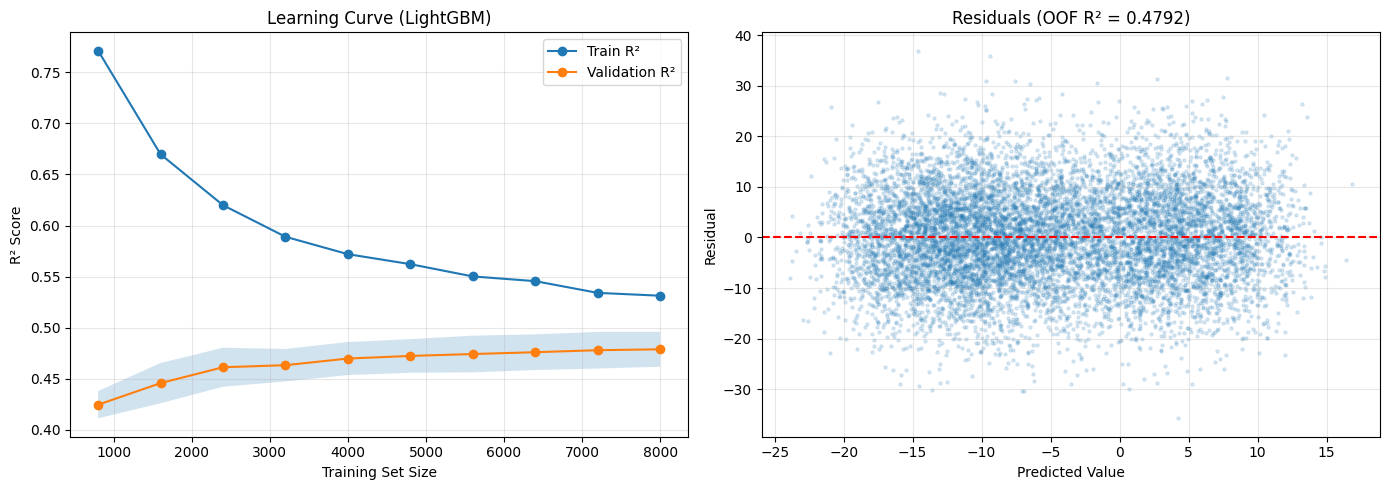


Train R² at full data:      0.5313
Validation R² at full data: 0.4788
Gap: 0.0525
-> Validation curve is flat: approaching irreducible noise ceiling.


In [8]:
print('Computing learning curve...')
start = time.time()

train_sizes, train_scores, val_scores = learning_curve(
    lgb_eng, X_eng, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv, scoring='r2', n_jobs=-1
)

elapsed = time.time() - start
print(f'Completed in {elapsed:.1f}s')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Learning Curve
ax = axes[0]
ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train R²')
ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation R²')
ax.fill_between(train_sizes,
                val_scores.mean(axis=1) - val_scores.std(axis=1),
                val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.2)
ax.set_xlabel('Training Set Size')
ax.set_ylabel('R² Score')
ax.set_title('Learning Curve (LightGBM)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Residual Analysis
pred_oof = cross_val_predict(lgb_eng, X_eng, y, cv=cv, n_jobs=-1)
residuals = y - pred_oof

ax = axes[1]
ax.scatter(pred_oof, residuals, alpha=0.15, s=5)
ax.axhline(y=0, color='red', linestyle='--')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Residual')
ax.set_title(f'Residuals (OOF R² = {r2_score(y, pred_oof):.4f})')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Diagnose
print(f'\nTrain R² at full data:      {train_scores.mean(axis=1)[-1]:.4f}')
print(f'Validation R² at full data: {val_scores.mean(axis=1)[-1]:.4f}')
gap = train_scores.mean(axis=1)[-1] - val_scores.mean(axis=1)[-1]
print(f'Gap: {gap:.4f}')
if gap > 0.15:
    print('-> Large gap: model is overfitting. More regularization or data could help.')
elif val_scores.mean(axis=1)[-1] - val_scores.mean(axis=1)[-3] < 0.005:
    print('-> Validation curve is flat: approaching irreducible noise ceiling.')
else:
    print('-> Validation still improving: more data would likely help.')

## Summary

In [ ]:
print('=== EXPERIMENT RESULTS ===')
print(f'Current best (Stacking + Engineered): 0.4807')
print(f'---')
print(f'Exp 1 - Feature Selection:  (check above)')
print(f'Exp 2 - Target Encoding:    {scores_te.mean():.4f}')
print(f'Exp 4 - Learning Curve:     see plots above')

=== EXPERIMENT RESULTS ===
Current best (Stacking + Engineered): 0.4807
---
Exp 1 - Feature Selection:  (check above)
Exp 2 - Target Encoding:    0.4777
Exp 3 - Weighted Averaging: 0.4807
Exp 4 - Learning Curve:     see plots above
